In [1]:
from __future__ import absolute_import, division, print_function

import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, accuracy_score

import torch
# from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro.distributions import Normal, Uniform, Delta
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, JitTrace_ELBO, TracePredictive
from pyro.contrib.autoguide import AutoMultivariateNormal
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc.util import diagnostics
# import pyro.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from pyro.ops.stats import waic
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from copy import deepcopy
pyro.set_rng_seed(1)
assert pyro.__version__.startswith('0.4.1')

In [2]:
from sklearn.linear_model import LinearRegression, LogisticRegression

## Read Data

In [3]:
%matplotlib inline
logging.basicConfig(format='%(message)s', level=logging.INFO)
# Enable validation checks
pyro.enable_validation(True)
smoke_test = ('CI' in os.environ)
pyro.set_rng_seed(1)

In [4]:
data = pd.read_csv('data/crap.csv')

In [5]:
data.columns

Index(['Unnamed: 0', 'month', 'CensusTract', 'TotalPop', 'Income', 'IncomeErr',
       'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'ChildPoverty',
       'Professional', 'Service', 'Office', 'Construction', 'Production',
       'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment', 'FELONY', 'MISDEMEANOR',
       'VIOLATION', 'restaurants', 'bar', 'park', 'subway_station'],
      dtype='object')

In [6]:
data['target'] = data.apply(lambda row : row['FELONY'] + row['MISDEMEANOR'] + row['VIOLATION'], axis=1)
# data['target'] = data.apply(lambda row : row['FELONY'] , axis=1)

In [7]:
data['target'] = data['target'].astype(int)

In [8]:
def get_data(data, features, target):

    
    ###pick only the tables required#####
    one_table = data[data[target]==1]
    zero_table = data[data[target]==0]
    one_indices = len(one_table)
    zero_indices = len(zero_table)
    
    if one_indices < zero_indices:
        zero_table = zero_table.sample(one_indices)
    else:
        one_table = one_table.sample(zero_indices)
    
    table = one_table.append(zero_table, ignore_index=True)
    
    df_X = table[features]
    df_y = table[target]
    
    
        

    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2)
    # Train Data
    X_np_train = normalize(np.array(X_train))
    y_np_train = np.array(y_train)
    

        

    X_nuts_train = torch.from_numpy(X_np_train).type(torch.float32)
    y_nuts_train = torch.from_numpy(y_np_train).type(torch.float32)

    population =  torch.from_numpy(np.array(X_train['TotalPop'])).type(torch.float32)

    #Test Data
    X_np_test = normalize(np.array(X_test))
    y_np_test = np.array(y_test)

    X_nuts_test = torch.from_numpy(X_np_test).type(torch.float32)
    y_nuts_test = torch.from_numpy(y_np_test).type(torch.float32)

    test_population =  torch.from_numpy(np.array(X_test['TotalPop'])).type(torch.float32)
    return X_nuts_train, y_nuts_train, population, X_nuts_test, y_nuts_test, test_population


## Feature Vizualizing

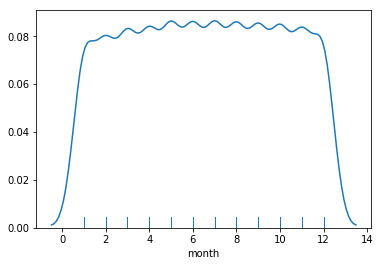

In [9]:
sns.distplot(data['month'], hist=False, rug=True);


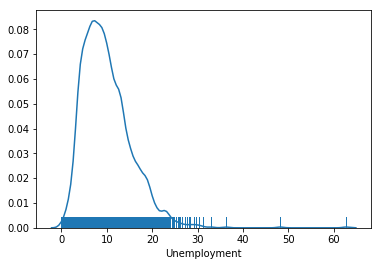

In [10]:
sns.distplot(data['Unemployment'], hist=False, rug=True);


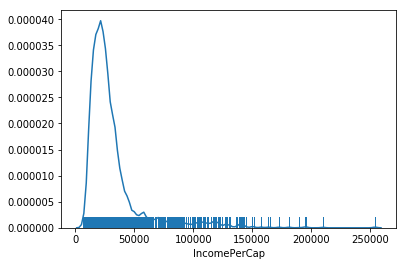

In [11]:
sns.distplot(data['IncomePerCap'], hist=False, rug=True);


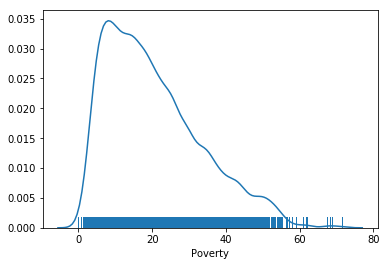

In [12]:
sns.distplot(data['Poverty'], hist=False, rug=True);


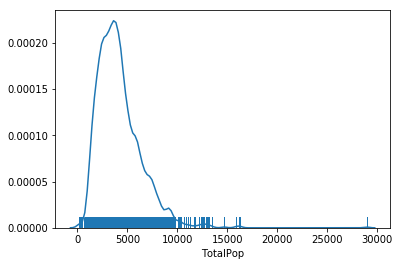

In [13]:
sns.distplot(data['TotalPop'], hist=False, rug=True);


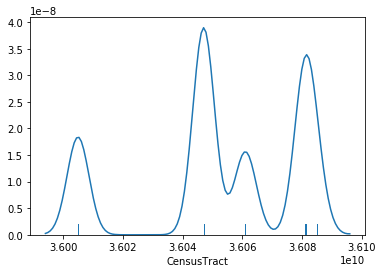

In [14]:
sns.distplot(data['CensusTract'], hist=False, rug=True);


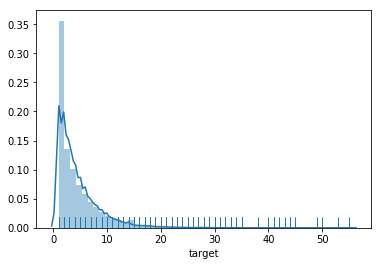

In [15]:
sns.distplot(data['target'], hist=True, rug=True);


In [16]:
data['target'].median()

3.0

In [17]:

len(data[data['target']>0])

21630

In [18]:
len(data[data['target']<=0])

0

In [19]:
bool_split = 0

In [20]:
high_risk_area = [1 if t>bool_split else 0 for t in list(data['target'])]

In [21]:
data['binary_target'] = high_risk_area

In [22]:
data['binary_target']

0        1
1        1
2        1
3        1
4        1
        ..
21625    1
21626    1
21627    1
21628    1
21629    1
Name: binary_target, Length: 21630, dtype: int64

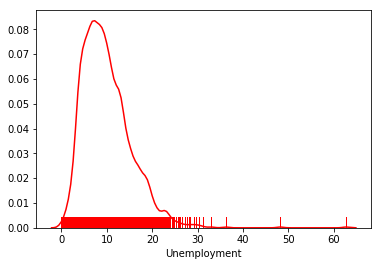

In [23]:
sns.distplot(data[data['binary_target']==1]['Unemployment'], hist=False, rug=True, color='r');
sns.distplot(data[data['binary_target']==0]['Unemployment'], hist=False, rug=True, color='b');


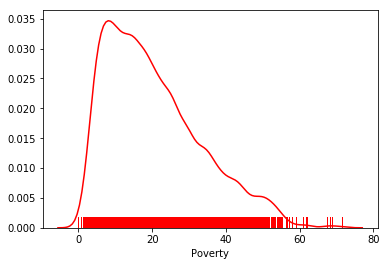

In [24]:
sns.distplot(data[data['binary_target']==1]['Poverty'], hist=False, rug=True, color='r');
sns.distplot(data[data['binary_target']==0]['Poverty'], hist=False, rug=True, color='b');


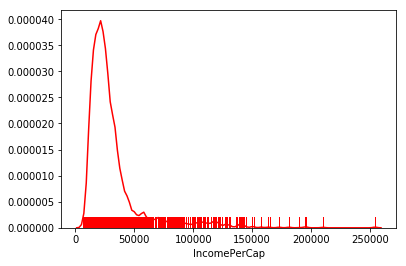

In [25]:
sns.distplot(data[data['binary_target']==1]['IncomePerCap'], hist=False, rug=True, color='r');
sns.distplot(data[data['binary_target']==0]['IncomePerCap'], hist=False, rug=True, color='b');


## Model 1

In [26]:
bool_split = 9
offset = 1
def sep_data(row):
    if row['target'] >= bool_split + offset :
        return 1
    elif row['target'] <= bool_split - offset :
        return 0
    else:
        return float('nan')
features = ['TotalPop', 'Income', 'IncomeErr',
       'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'ChildPoverty',
       'Professional', 'Service', 'Office', 'Construction', 'Production',
       'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment','restaurants', 'bar', 'park', 'subway_station']
target = 'binary_target'       
data_new = deepcopy(data)
data_new['binary_target'] = data_new.apply(sep_data, axis=1)
data_new = data_new.dropna()
print(len(data_new[data_new['binary_target']==0]), len(data_new[data_new['binary_target']==1]))
X_nuts_train, y_nuts_train, population, X_nuts_test, y_nuts_test, test_population = get_data(data_new, features, target)

18709 2143


In [29]:
def model(data_x, data_y, D):
    beta = []
    for i in range(D+1):
        beta.append(pyro.sample("beta"+str(i), dist.Normal(0., 100)))
            
    logit = beta[0]
    for i in range(D):
        logit = logit + beta[i+1]*data_x[:,i]
    
    
    p = 1. / (1 + torch.exp(-logit))

    with pyro.plate("data", len(data_y)):
        y = pyro.sample("obs",dist.Bernoulli(p), obs=data_y)
    
    

In [ ]:
nuts_kernel = NUTS(model, jit_compile=True, adapt_step_size=True)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=2000)
mcmc_run = mcmc.run(X_nuts_train, y_nuts_train,X_nuts_train.numpy().shape[1])

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}


Warmup:   0%|          | 0/3000 [00:00<?, ?it/s]/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  del sys.path[0]
/anaconda3/lib/python3.7/site-packages/pyro/poutine/subsample_messenger.py:56: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0., device=self.device)
warmup:   3%|▎         | 96/3000 [04:32<2:43:19,  3.37s/it, step size=2.37e-02, acc. prob=0.785]

In [75]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

In [76]:
for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")
    

Site: beta0
       mean       std        5%       25%       50%       75%       95%
0  0.029414  0.069966 -0.080478 -0.019018  0.029281  0.073281  0.148453 

Site: beta1
       mean       std        5%       25%       50%       75%       95%
0  0.496798  0.096222  0.334099  0.432014  0.497756  0.557834  0.651547 

Site: beta2
       mean       std        5%       25%       50%       75%       95%
0 -0.362895  0.078118 -0.485934 -0.414358 -0.365051 -0.309542 -0.234678 

Site: beta3
       mean       std        5%       25%       50%       75%       95%
0 -0.016962  0.093489 -0.173877 -0.078602 -0.018771  0.042388  0.134889 

Site: beta4
      mean       std       5%       25%       50%       75%       95%
0  0.47459  0.087327  0.32519  0.413128  0.475902  0.535849  0.616523 

Site: beta5
       mean       std        5%       25%       50%       75%      95%
0  0.126808  0.097798 -0.037966  0.060903  0.128649  0.195753  0.28413 

Site: beta6
      mean       std        5%       25%      

In [100]:
m_v = []

for k,v in summary(hmc_samples).items():
    mean = v['mean'][0]
    std = v['std'][0]
    m_v.append((mean, std))

In [101]:
m_v

[(0.02941366471350193, 0.06996645033359528),
 (0.4967981278896332, 0.09622181951999664),
 (-0.362895131111145, 0.07811818271875381),
 (-0.016961704939603806, 0.09348898380994797),
 (0.4745902121067047, 0.08732690662145615),
 (0.12680839002132416, 0.09779774397611618),
 (0.0012404173612594604, 0.10711648315191269),
 (0.004139093216508627, 0.10625006258487701),
 (0.002767351223155856, 0.10073893517255783),
 (0.0010778408031910658, 0.09336259216070175),
 (5.3137548093218356e-05, 0.09514512121677399),
 (0.0009954058332368731, 0.09649165719747543),
 (0.0035668504424393177, 0.09795033186674118),
 (0.0006384096341207623, 0.10321583598852158),
 (0.0006157629541121423, 0.09773114323616028),
 (0.1756805032491684, 0.11078561097383499),
 (0.003275634255260229, 0.1021222472190857),
 (0.0011815306497737765, 0.10029580444097519),
 (-0.0011183160822838545, 0.10062342882156372),
 (-0.0007201838889159262, 0.10080569982528687),
 (-0.0009169051190838218, 0.09884124994277954),
 (0.009972894564270973, 0.091

In [35]:
def predict(x):
    

In [79]:
sites = list(hmc_samples.keys())
sites

['beta0',
 'beta1',
 'beta2',
 'beta3',
 'beta4',
 'beta5',
 'beta6',
 'beta7',
 'beta8',
 'beta9',
 'beta10',
 'beta11',
 'beta12',
 'beta13',
 'beta14',
 'beta15',
 'beta16',
 'beta17',
 'beta18',
 'beta19',
 'beta20',
 'beta21',
 'beta22',
 'beta23',
 'beta24']

beta0
beta1
beta2
beta3
beta4
beta5
beta6
beta7
beta8
beta9
beta10
beta11
beta12
beta13
beta14
beta15
beta16
beta17
beta18
beta19
beta20
beta21
beta22
beta23
beta24


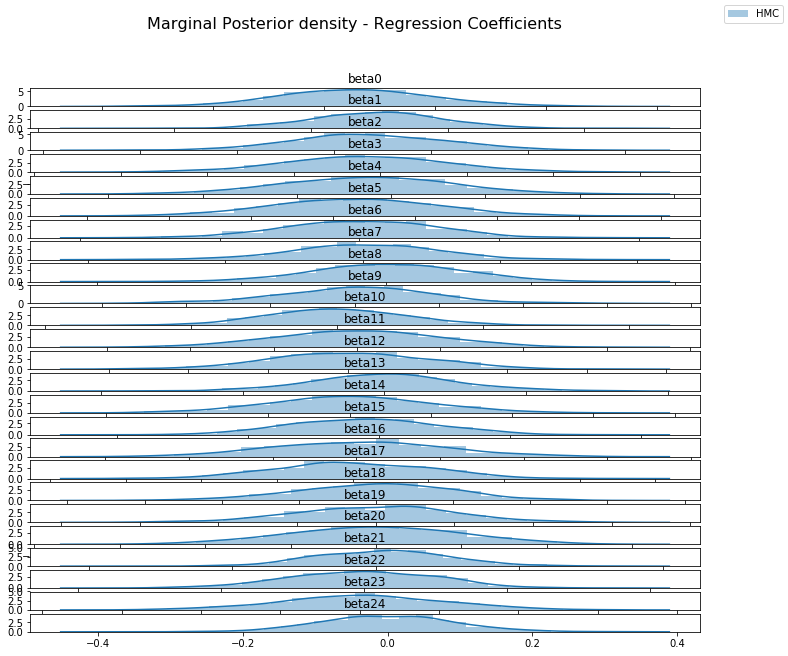

In [80]:
fig, axs = plt.subplots(nrows=25, ncols=1, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    print(site)
    sns.distplot(hmc_samples[site], ax=ax, label="HMC")        
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

In [67]:
m_v

[[0.15, 0.07], [1.71, 0.08], [0.01, 0.1], [0.01, 0.1], [-0.29, 0.07]]

In [102]:
def predict(data_x, D, m_v):
    """
    :param data_x: input test data
    :param D: number of features
    :param m_v: list of means and variances of beta distributions (coeffecients) obtained after mcmc sampling
    """
    beta = []
    for i in range(D+1):
        beta.append(pyro.sample("beta"+str(i), dist.Normal(m_v[i][0], m_v[i][1])))
            
    logit = beta[0]
    for i in range(D):
        logit = logit + beta[i+1]*data_x[:,i]

    p = 1. / (1 + torch.exp(-logit))
    yield dist.Bernoulli(p).sample()


In [104]:
results = torch.stack(list(predict(X_nuts_test, X_nuts_test.numpy().shape[1], m_v)))

In [106]:
results.shape

torch.Size([1, 858])

In [107]:
y_pred = results.numpy()[0].transpose()
acc_model_1 = accuracy_score(y_pred, y_nuts_test)

In [108]:
acc_model_1

0.49417249417249415

## Model 2: Improving model 1, incorporating unstructured spatial R.V 

In [104]:
def model(data_x, data_y, D):
    
    beta = []
    for i in range(D+1):
        beta.append(pyro.sample("beta"+str(i), dist.Normal(0., 0.0001)))
        
    sd_u = pyro.sample("sd_u",dist.Uniform(0,100))
    
    logit = beta[0]
    for i in range(D):
        logit = logit + beta[i+1]*data_x[:,i]
    
    
    sigma2_ui = 1/(sd_u**2) 
    u_i = pyro.sample("u_i",dist.Normal(0, sigma2_ui))
    logit += u_i
    
    p = 1. / (1 + torch.exp(-logit))

    with pyro.plate("data", len(data_y)):
        y = pyro.sample("obs",dist.Bernoulli(p), obs=data_y)
    
    

In [105]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=30000, warmup_steps=200)
mcmc_run = mcmc.run(X_nuts_train, y_nuts_train,X_nuts_train.numpy().shape[1])

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}


sample: 100%|██████████| 1200/1200 [09:41<00:00,  2.07it/s, step size=7.25e-03, acc. prob=0.902]


In [106]:

# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

In [107]:
for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: beta0
           mean       std        5%       25%       50%       75%       95%
0 -3.115552e-08  0.000099 -0.000159 -0.000065 -0.000003  0.000069  0.000159 

Site: beta1
       mean     std        5%       25%           50%      75%       95%
0  0.000002  0.0001 -0.000156 -0.000068 -4.813965e-07  0.00007  0.000167 

Site: beta2
       mean       std        5%       25%       50%       75%       95%
0  0.000003  0.000101 -0.000152 -0.000066  0.000004  0.000071  0.000161 

Site: beta3
       mean       std        5%       25%           50%      75%       95%
0 -0.000002  0.000098 -0.000162 -0.000061 -1.928292e-07  0.00006  0.000159 

Site: beta4
       mean     std        5%       25%       50%       75%      95%
0 -0.000002  0.0001 -0.000166 -0.000067 -0.000002  0.000065  0.00016 

Site: beta5
       mean       std        5%       25%       50%       75%       95%
0  0.000003  0.000096 -0.000151 -0.000061  0.000002  0.000067  0.000162 

Site: beta6
           mean       std     

In [108]:
sites = list(hmc_samples.keys())
sites

['beta0', 'beta1', 'beta2', 'beta3', 'beta4', 'beta5', 'beta6', 'sd_u', 'u_i']

beta0
beta1
beta2
beta3
beta4
beta5
beta6
sd_u
u_i


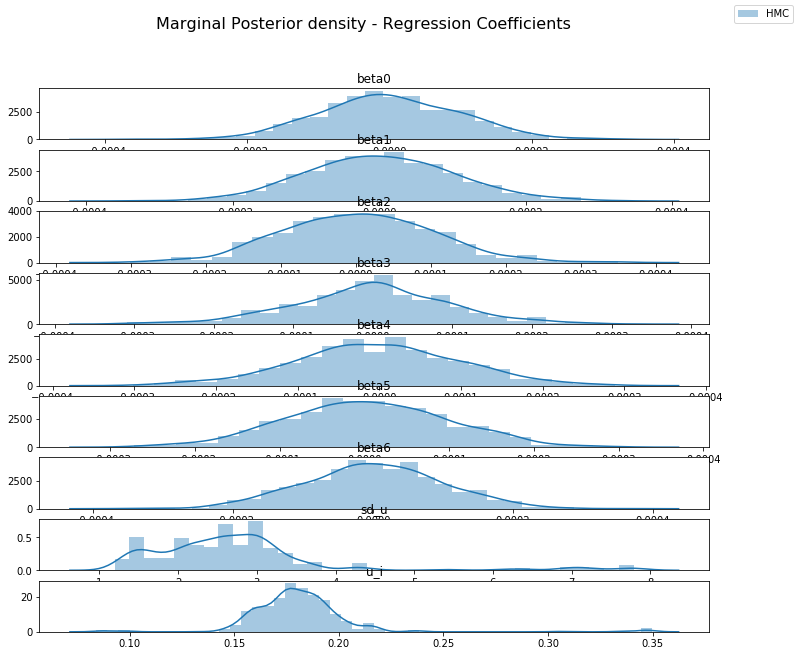

In [114]:
fig, axs = plt.subplots(nrows=9, ncols=1, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    print(site)
    sns.distplot(hmc_samples[site], ax=ax, label="HMC")        
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

In [115]:
def predict(X_nuts_test, test_population, mean_hmc_samples):
    output = mean_hmc_samples['beta0']
    for i in range(X_nuts_test.numpy().shape[1]):
        output += mean_hmc_samples['beta{}'.format(i+1)]*X_nuts_test[:,i]
    output += mean_hmc_samples['u_i']
    p = 1. / (1 + torch.exp(-output))
    yield dist.Bernoulli(p).sample()
    

In [117]:
mean_hmc_samples = {}
for k,v in hmc_samples.items():
    mean_hmc_samples[k] = np.mean(hmc_samples[k])

In [118]:
results = torch.stack(list(predict(X_nuts_test, test_population, mean_hmc_samples)))

y_pred = results.numpy()[0].transpose()
acc_model_2 = accuracy_score(y_pred, y_nuts_test)

In [120]:
acc_model_2

0.5015795868772782

## Model 3: Improving model 2, incorporating the space related terms

In [121]:
data['CensusTract']

0        36005000200
1        36005000400
2        36005001600
3        36005001900
4        36005002000
            ...     
20567    36085030301
20568    36085030302
20569    36085031901
20570    36085031902
20571    36085032300
Name: CensusTract, Length: 20572, dtype: int64

## Building the Conditional Auto Regressor Module

In [122]:
census_ids = {}
i = 0
for ct in data['CensusTract']:
    if ct not in census_ids:
        census_ids[ct] = i
        i += 1

In [123]:
data['CensusIds'] = [census_ids[c] for c in data['CensusTract']]

In [66]:
len(census_ids)

2092

In [77]:
W = np.ones((len(census_ids), len(census_ids))) #Should be neighbourhood matrix instead

In [79]:
W_star = W/(np.sum(W, axis=0) + 1)

In [81]:
s_i = np.sum(W_star, axis=0)

In [ ]:
#complete Car model

In [ ]:
def model(data_x, data_y, D):
    
    beta = []
    for i in range(D+1):
        beta.append(pyro.sample("beta"+str(i), dist.Normal(0., 0.0001)))
        
    sd_u = pyro.sample("sd_u",dist.Uniform(0,100))
    
    logit = beta[0]
    for i in range(D):
        logit = logit + beta[i+1]*data_x[:,i]
    
    
    sigma2_ui = 1/(sd_u**2) 
    u_i = pyro.sample("u_i",dist.Normal(0, sigma2_ui))
    logit += u_i
    
    p = 1. / (1 + torch.exp(-logit)) 
    
#     s_i = 
    

    with pyro.plate("data", len(data_y)):
        y = pyro.sample("obs",dist.Bernoulli(p), obs=data_y)
    